# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [2]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode
# from src.Inference import Inference
# from src.Subspace import Subspace
# from src.model import Model
# from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [5]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.35417699419094
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.779125916898224
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.0920445

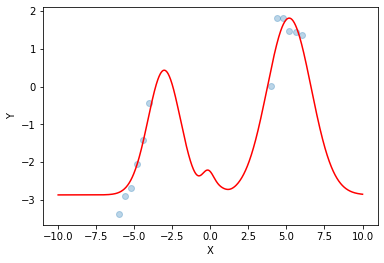

In [6]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');


## random

In [7]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=0.25)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [8]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [9]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

In [10]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [11]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -101.71860603718989; gradient mag: 83.63501903786754
Iteration 200 lower bound -37.84114382743719; gradient mag: 29.80615640460935
Iteration 400 lower bound -20.32003980150998; gradient mag: 16.3193247527129
Iteration 600 lower bound -14.135590835413714; gradient mag: 7.828823831763019
Iteration 800 lower bound -12.07166625521075; gradient mag: 4.6240880314541
Iteration 1000 lower bound -11.070217912586799; gradient mag: 3.271179226397087
Iteration 1200 lower bound -10.485116086013793; gradient mag: 2.182483906165109
Iteration 1400 lower bound -10.189712237773454; gradient mag: 2.606723139286066
Iteration 1600 lower bound -10.090291597299073; gradient mag: 1.7436692218878989
Iteration 1800 lower bound -9.89191011408004; gradient mag: 1.2015857593766734
Iteration 2000 lower bound -9.865108321073667; gradient mag: 1.2796441130704965
Iteration 2200 lower bound -9.7754861089294; gradient mag: 0.5681014869491198
Iteration 2400 lower bound -9.771061860643522; gradient

In [13]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.10 min


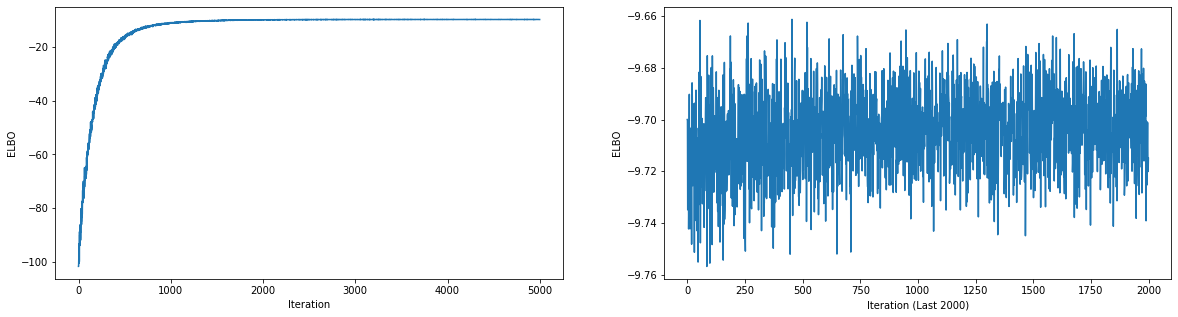

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [15]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

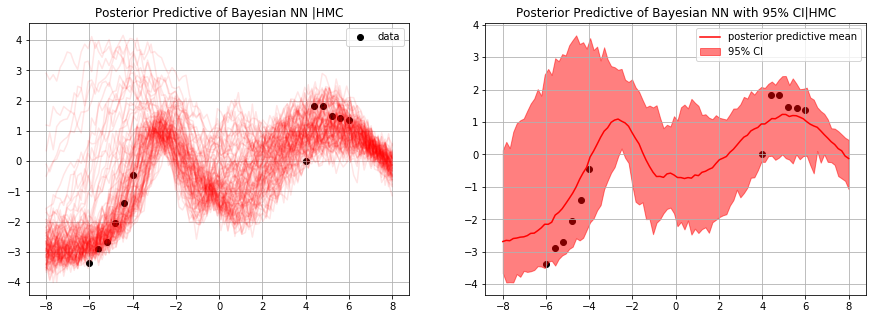

In [16]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

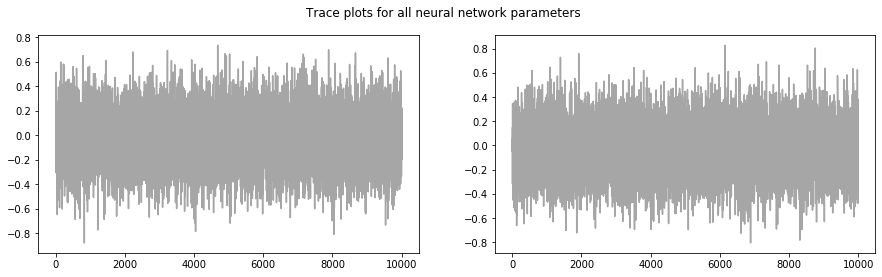

In [17]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

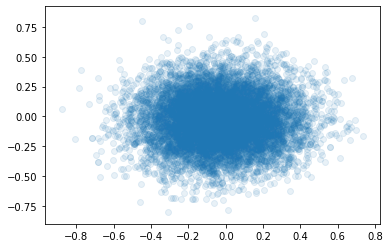

In [20]:
plt.scatter(post_sample[:,0], post_sample[:,1], alpha = 0.1)

## PCA

In [21]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=0.25)
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [22]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [23]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

In [24]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [25]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -573501369374.6138; gradient mag: 3292327.86003555
Iteration 200 lower bound -573498083799.6577; gradient mag: 3292226.6583051896
Iteration 400 lower bound -573494713640.8567; gradient mag: 3292410.3518972555
Iteration 600 lower bound -573491530677.9032; gradient mag: 3292460.717200881
Iteration 800 lower bound -573488125428.7223; gradient mag: 3291965.3959613964
Iteration 1000 lower bound -573484929582.0037; gradient mag: 3291985.839255496
Iteration 1200 lower bound -573481587811.0931; gradient mag: 3292010.251943123
Iteration 1400 lower bound -573478412826.7091; gradient mag: 3296019.768990913
Iteration 1600 lower bound -573475061336.093; gradient mag: 3292433.2079089987
Iteration 1800 lower bound -573471790943.7615; gradient mag: 3292269.431709218
Iteration 2000 lower bound -573468480642.186; gradient mag: 3295697.8351067766
Iteration 2200 lower bound -573465216345.2502; gradient mag: 3291900.7352587823
Iteration 2400 lower bound -573461940961.729; gradient m

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.00 min


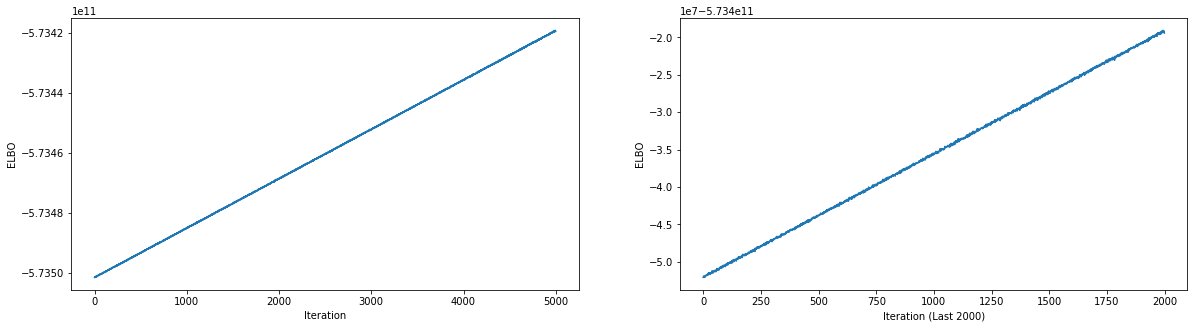

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [28]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

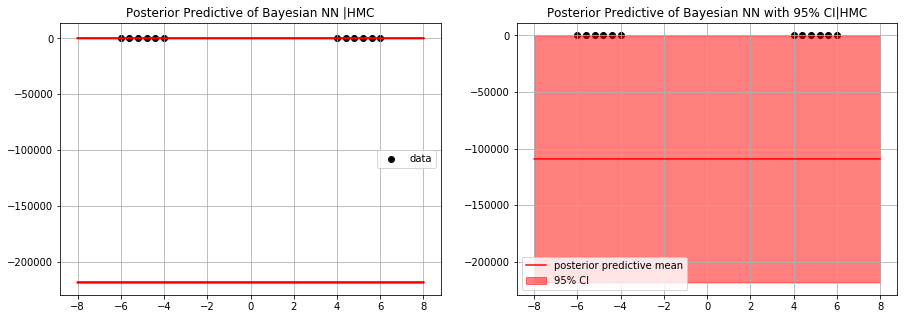

In [29]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()